# Import libraries

In [2]:
import os
import cv2
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt

### Other dependencies ###
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

### Tensorflow dependencies ###
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

### Some constants ###
input_dim = 12 # 48
weights_dir = 'road_signs'
pnet_tensorboard_logdir = 'pnet_logs'
rnet_tensorboard_logdir = 'rnet_logs'
onet_tensorboard_logdir = 'onet_logs'

pnet_weights = f'weights/{weights_dir}/pnet.weights.hdf5'
rnet_weights = f'weights/{weights_dir}/rnet.weights.hdf5'
onet_weights = f'weights/{weights_dir}/onet.weights.hdf5'

if(not os.path.exists(f'weights/{weights_dir}')):
    print('[INFO] Created weight directory ...')
    os.mkdir(f'weights/{weights_dir}')
    
if(os.path.exists(pnet_tensorboard_logdir)):
    print('[INFO] Clearing P-Net log directory ... ')
    shutil.rmtree(pnet_tensorboard_logdir)

if(os.path.exists(rnet_tensorboard_logdir)):
    print('[INFO] Clearing R-Net log directory ... ')
    shutil.rmtree(rnet_tensorboard_logdir)

if(os.path.exists(onet_tensorboard_logdir)):
    print('[INFO] Clearing O-Net log directory ... ')
    shutil.rmtree(onet_tensorboard_logdir)
    
epochs = 500
batch_size = 16
pnet_tensorboard = TensorBoard(log_dir=pnet_tensorboard_logdir)
pnet_checkpoint = ModelCheckpoint(pnet_weights, save_weights_only=True)
pnet_callbacks = [pnet_tensorboard, pnet_checkpoint]

rnet_tensorboard = TensorBoard(log_dir=rnet_tensorboard_logdir)
rnet_checkpoint = ModelCheckpoint(rnet_weights, save_weights_only=True)
rnet_callbacks = [rnet_tensorboard, rnet_checkpoint]

onet_tensorboard = TensorBoard(log_dir=onet_tensorboard_logdir)
onet_checkpoint = ModelCheckpoint(onet_weights, save_weights_only=True)
onet_early_stop1 = EarlyStopping(monitor='val_probability_loss', patience=15, verbose=1)
onet_early_stop2 = EarlyStopping(monitor='val_bbox_regression_loss', patience=15, verbose=1)
onet_callbacks = [onet_tensorboard, onet_checkpoint]

train_dir = "./road_signs/images"
test_dir = "/home/minhhieu/Desktop/Hieu/datasets/GTSDB/TestIJCNN2013/TestIJCNN2013Download"

[INFO] Created weight directory ...


# Load and explore dataset

In [3]:
def load_raw_dataset(dataset_dir, gt_file, delimiter=';', max_n_samples=3000):
    '''
        This function will take in a dataset directory with ppm images (according to the DTSDB dataset)
        then it will return a list where each element is a list of 3 items. First item is the image, the
        second item is the bounding box and the last is the class ID.
        
        Params :
            @dataset_dir : Dataset directory.
            @gt_file : The file that consists of ground truth annotation in the format
            <img_pth>;<left>;<top>;<right>;<bottom>;<class_idx>.
            @delimiter : The separator of each item in each line of the ground truth file
            
        Returns :
            raw_dataset : list of elements [<cv2_img>, <gt_bbox>, <class_idx>]
    '''
    gt_abs_path = os.path.join(dataset_dir, gt_file)
    class_ids = {}
    lines = open(gt_abs_path, 'r').readlines()
    
    print('[INFO] From images to ground truth ... ')
    images_to_gt = [[x.strip().split(delimiter)[0],   # Image path
                     x.strip().split(delimiter)[1:5], # Bbox regression ground truth
                     x.strip().split(delimiter)[5]]   # The class index
                    for x in lines]
    
    print('[INFO] Converting to raw dataset ... ')
    raw_dataset = [[cv2.cvtColor(cv2.imread(os.path.join(dataset_dir, x[0])), cv2.COLOR_BGR2RGB),
                    np.array(x[1]).astype('int'),
                    x[2]] 
                  for x in images_to_gt[:max_n_samples]]
    
    print(f'[INFO] {len(raw_dataset)} samples loaded ... ')
    
    return raw_dataset
    
# raw_dataset = load_raw_dataset(train_dir, 'gt.txt')

# ### Visualize sample data ###
# img = raw_dataset[1][0].copy()
# bbox = raw_dataset[1][1]
# x1, y1, x2, y2 = bbox
# img = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
# plt.imshow(img)
# plt.show()

### Generating negative samples (samples without traffic signs)

In [4]:
def generate_neg_samples(raw_dataset, frame_per_img=4, crop_size=(48, 48)):
    '''
        This function will generate croppings of fixed size without any traffic sign
        and return those croppings with dummy bbox ground truth
        
        Params:
            @raw_dataset : The raw dataset formated similarly above
            @crop_size : The fixed cropping size
            
        Return:
            neg_samples : A list in format [<crop_img>,<dummy_bbox>,0]
    '''
    neg_samples = []
    for img, bbox, class_id in raw_dataset:
        for i in range(frame_per_img):
            height, width = img.shape[:2]
            x1, y1, x2, y2 = bbox
            range_x = ((0, max(x1 - crop_size[0], 0)), (min(x2 + crop_size[0], width), width))
            range_y = ((0, max(y1 - crop_size[1], 0)), (min(y2 + crop_size[1], height), height))

            ### Generate a random x,y coordinates ###
            x = random.choice([random.randint(range_x[0][0], range_x[0][1]), 
                               random.randint(range_x[1][0], range_x[1][1])])
            y = random.choice([random.randint(range_y[0][0], range_y[0][1]), 
                               random.randint(range_y[1][0], range_y[1][1])])

            # regenerate if cropping does not satisfy the size requirements
            while(width - x < crop_size[0] or height - y < crop_size[1]):
                x = random.choice([random.randint(range_x[0][0], range_x[0][1]), 
                               random.randint(range_x[1][0], range_x[1][1])])
                y = random.choice([random.randint(range_y[0][0], range_y[0][1]), 
                               random.randint(range_y[1][0], range_y[1][1])])

            crop = img[y:y+crop_size[1], x:x+crop_size[0]]
            neg_samples.append([crop, np.array([0,0,0,0]), 0])
        
    print(f'[INFO] {len(neg_samples)} negative samples generated ... ')
    return np.array(neg_samples)

# neg_samples = generate_neg_samples(raw_dataset, crop_size=(input_dim,input_dim))
# plt.imshow(neg_samples[1][0].copy())
# plt.show()

### Generate positive samples (samles with traffic signs)

In [5]:
def generate_pos_samples(raw_dataset, pad_range=(10, 100), frame_per_img=4, img_size=48):
    '''
        This function will generate croppings with traffic signs
        and return those croppings with bbox ground truth
        
        Params:
            @raw_dataset : The raw dataset formated similarly above
            @pad_range : The pad range around the ground truth bounding box
            
        Return:
            pos_samples : A list in format [<crop_img>,<bbox>,1]
    '''
    pos_samples = []
    for img, bbox, class_id in raw_dataset:
        for i in range(frame_per_img):
            height, width = img.shape[:2]
            x1, y1, x2, y2 = bbox
            pad_x1 = min(x1, random.randint(pad_range[0], pad_range[1]))
            pad_x2 = min(width - x2, random.randint(pad_range[0], pad_range[1]))
            pad_y1 = min(y1, random.randint(pad_range[0], pad_range[1]))
            pad_y2 = min(height - y2, random.randint(pad_range[0], pad_range[1]))

            crop = img[y1 - pad_y1:y2 + pad_y2, x1 - pad_x1:x2 + pad_x2]
            h, w = crop.shape[:2]

            gt = np.array([pad_x1, pad_y1, pad_x1 + x2 - x1, pad_y1 + y2 - y1])
            gt[2] = gt[2] - gt[0] # Calculates width
            gt[3] = gt[3] - gt[1] # Calculates height
            gt = np.multiply(gt, np.array([1/w, 1/h, 1/w, 1/h])).astype('float32')

            crop = cv2.resize(crop, (img_size, img_size))
            pos_samples.append([crop, gt, class_id])
        
    print(f'[INFO] {len(pos_samples)} positive samples generated ... ')
    return np.array(pos_samples)

# pos_samples = generate_pos_samples(raw_dataset, pad_range=(5, 15), img_size=input_dim)

# img, gt, label = pos_samples[6]
# img = img.copy()
# h, w = img.shape[:2]
# x1, y1, w, h = np.multiply(gt, np.array([w,h,w,h])).astype('int')

# img = cv2.rectangle(img, (x1, y1), (x1+w, y1+h), 2)
# plt.imshow(img)
# plt.show()

### Combine negative and positive samples to form training dataset

In [6]:
# Generate raw data from firectory
raw_dataset = load_raw_dataset(train_dir, 'gt.txt')
neg_samples = generate_neg_samples(raw_dataset, frame_per_img=4, crop_size=(input_dim,input_dim))
pos_samples = generate_pos_samples(raw_dataset, pad_range=(5, 15), frame_per_img=4, img_size=input_dim)
pos_samples[:, 2] = 1.0
# pos_samples[:,2] = LabelEncoder().fit_transform(pos_samples[:, 2])
# pos_samples[:,2] += 1

# Concatenate two groups and shuffle
train_dataset = np.concatenate([pos_samples, neg_samples])
np.random.shuffle(train_dataset)

train_images = np.array([x[0] for x in train_dataset])
train_bboxes = np.array([x[1] for x in train_dataset])
train_labels = OneHotEncoder().fit_transform(train_dataset[:,2].reshape(-1, 1)).toarray()

train_bboxes = train_bboxes.reshape(-1, 1, 1, 4)
train_labels = train_labels.reshape(-1, 1, 1, train_labels.shape[1])

train_images = ((train_images - 127.5) / 127.5).astype('float32')
train_bboxes = train_bboxes.astype('float32')
train_labels = train_labels.astype('float32')

[INFO] From images to ground truth ... 
[INFO] Converting to raw dataset ... 
[INFO] 1244 samples loaded ... 
[INFO] 4976 negative samples generated ... 
[INFO] 4976 positive samples generated ... 


<ipython-input-4-223f64bb23c3>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(neg_samples)
<ipython-input-5-280b28c2d059>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pos_samples)


# Implement P-Net architecture

In [7]:
def conv_block(in_filters, out_filters, kernel_size=3, batch_norm=False):
    inputs = Input(shape=(None, None, in_filters))
    p_layer = Conv2D(out_filters, kernel_size=kernel_size, strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(inputs)
    if(batch_norm) : p_layer = BatchNormalization()(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
        
    p_layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(p_layer)
    
    block = Model(inputs = inputs, outputs=p_layer)
    return block

def build_pnet_model(input_shape=None, batch_norm=True, dropout=False, n_classes=2, activation='relu'):
    if(input_shape is not None):
        if(input_shape not in [12, 24, 48, 112, 224]):
            raise Exception('Input shape must be in 12, 24, 48')
    
    inputs = Input(shape=(None, None, 3))
    p_layer = conv_block(3, 10, kernel_size=3, batch_norm=batch_norm)(inputs)
    
    if(input_shape is not None):
        if(input_shape >= 24):
            p_layer = conv_block(10, 10, kernel_size=3, batch_norm=batch_norm)(p_layer)
    
    if(input_shape is not None):
        if(input_shape >= 48):
            p_layer = conv_block(10, 10, kernel_size=3, batch_norm=batch_norm)(p_layer)
            
    if(input_shape is not None):
        if(input_shape >= 112):
            p_layer = conv_block(10, 10, kernel_size=3, batch_norm=batch_norm)(p_layer)

    p_layer = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
        
    p_layer = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(dropout) : p_layer = Dropout(0.5)(p_layer)

    p_layer_out1 = Conv2D(n_classes, kernel_size=(1, 1), strides=(2, 2))(p_layer)
    p_layer_out1 = Softmax(axis=3, name='probability')(p_layer_out1)
    p_layer_out2 = Conv2D(4, kernel_size=(1, 1), strides=(2, 2), activation='sigmoid', name='bbox_regression')(p_layer)

    p_net = Model(inputs, [p_layer_out1, p_layer_out2], name='P-Net')

    return p_net

n_classes = train_labels.shape[3]
pnet = build_pnet_model(input_shape=input_dim, batch_norm=True, dropout=True,
                        n_classes=n_classes)
print(pnet(tf.random.normal((1,input_dim,input_dim,3)))[1].shape)
print(pnet.summary())

(1, 1, 1, 4)
Model: "P-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, None, None, 1 330         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 1456        model[0][0]                      
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, None, None, 1 16          conv2d_1[0][0]                   
_________________________________________________________________________________

# Start training P-Net

In [8]:
losses = {
    'probability' : BinaryCrossentropy(from_logits=False),
    'bbox_regression' : tfa.losses.GIoULoss() # MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO)
}

y = {
    'probability' : train_labels,
    'bbox_regression' : train_bboxes
}

if(os.path.exists(pnet_weights)):
    print('[INFO] Loading P-Net pretrained weights ...')
    pnet.load_weights(pnet_weights)
pnet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses,
            metrics={'probability':'accuracy'})

In [9]:
history = pnet.fit(train_images, y, epochs=epochs, batch_size=batch_size, callbacks=pnet_callbacks)

Epoch 1/500
622/622 [==============================] - 8s 10ms/step - loss: 2.3215 - probability_loss: 0.7300 - bbox_regression_loss: 1.5838 - probability_accuracy: 0.5050
Epoch 2/500
622/622 [==============================] - 6s 9ms/step - loss: 2.2026 - probability_loss: 0.6412 - bbox_regression_loss: 1.5537 - probability_accuracy: 0.6040
Epoch 3/500
622/622 [==============================] - 6s 9ms/step - loss: 2.0219 - probability_loss: 0.5971 - bbox_regression_loss: 1.4172 - probability_accuracy: 0.6576
Epoch 4/500
622/622 [==============================] - 6s 9ms/step - loss: 1.8121 - probability_loss: 0.5628 - bbox_regression_loss: 1.2415 - probability_accuracy: 0.6969
Epoch 5/500
622/622 [==============================] - 6s 9ms/step - loss: 1.7038 - probability_loss: 0.5455 - bbox_regression_loss: 1.1506 - probability_accuracy: 0.7171
Epoch 6/500
622/622 [==============================] - 6s 9ms/step - loss: 1.6017 - probability_loss: 0.5169 - bbox_regression_loss: 1.0771 - pr

622/622 [==============================] - 6s 9ms/step - loss: 1.0466 - probability_loss: 0.1863 - bbox_regression_loss: 0.8520 - probability_accuracy: 0.9321
Epoch 49/500
622/622 [==============================] - 6s 9ms/step - loss: 1.0358 - probability_loss: 0.1792 - bbox_regression_loss: 0.8482 - probability_accuracy: 0.9376
Epoch 50/500
622/622 [==============================] - 6s 9ms/step - loss: 1.0437 - probability_loss: 0.1895 - bbox_regression_loss: 0.8458 - probability_accuracy: 0.9351
Epoch 51/500
622/622 [==============================] - 6s 9ms/step - loss: 1.0387 - probability_loss: 0.1769 - bbox_regression_loss: 0.8534 - probability_accuracy: 0.9375
Epoch 52/500
622/622 [==============================] - 6s 10ms/step - loss: 1.0432 - probability_loss: 0.1801 - bbox_regression_loss: 0.8547 - probability_accuracy: 0.9399
Epoch 53/500
622/622 [==============================] - 6s 9ms/step - loss: 1.0340 - probability_loss: 0.1789 - bbox_regression_loss: 0.8468 - probabili

622/622 [==============================] - 6s 9ms/step - loss: 0.9469 - probability_loss: 0.1271 - bbox_regression_loss: 0.8113 - probability_accuracy: 0.9593
Epoch 96/500
622/622 [==============================] - 6s 9ms/step - loss: 0.9454 - probability_loss: 0.1300 - bbox_regression_loss: 0.8068 - probability_accuracy: 0.9547
Epoch 97/500
622/622 [==============================] - 6s 9ms/step - loss: 0.9528 - probability_loss: 0.1328 - bbox_regression_loss: 0.8114 - probability_accuracy: 0.9536
Epoch 98/500
622/622 [==============================] - 6s 9ms/step - loss: 0.9413 - probability_loss: 0.1268 - bbox_regression_loss: 0.8059 - probability_accuracy: 0.9573
Epoch 99/500
622/622 [==============================] - 6s 9ms/step - loss: 0.9406 - probability_loss: 0.1274 - bbox_regression_loss: 0.8045 - probability_accuracy: 0.9587
Epoch 100/500
622/622 [==============================] - 6s 9ms/step - loss: 0.9346 - probability_loss: 0.1202 - bbox_regression_loss: 0.8057 - probabili

622/622 [==============================] - 6s 9ms/step - loss: 0.8894 - probability_loss: 0.1009 - bbox_regression_loss: 0.7798 - probability_accuracy: 0.9656
Epoch 143/500
622/622 [==============================] - 6s 10ms/step - loss: 0.8982 - probability_loss: 0.1090 - bbox_regression_loss: 0.7805 - probability_accuracy: 0.9647
Epoch 144/500
622/622 [==============================] - 6s 9ms/step - loss: 0.8954 - probability_loss: 0.1061 - bbox_regression_loss: 0.7806 - probability_accuracy: 0.9625
Epoch 145/500
622/622 [==============================] - 6s 9ms/step - loss: 0.8885 - probability_loss: 0.0982 - bbox_regression_loss: 0.7815 - probability_accuracy: 0.9698
Epoch 146/500
622/622 [==============================] - 6s 9ms/step - loss: 0.8952 - probability_loss: 0.1066 - bbox_regression_loss: 0.7799 - probability_accuracy: 0.9643
Epoch 147/500
622/622 [==============================] - 6s 9ms/step - loss: 0.9072 - probability_loss: 0.1129 - bbox_regression_loss: 0.7856 - prob

KeyboardInterrupt: 

# Start training R-Net

In [15]:
# Generate raw data from firectory
raw_dataset = load_raw_dataset(train_dir, 'gt.txt')
neg_samples = generate_neg_samples(raw_dataset, frame_per_img=5, crop_size=(input_dim*2,input_dim*2))
pos_samples = generate_pos_samples(raw_dataset, pad_range=(10, 30), frame_per_img=4, img_size=input_dim*2)
pos_samples[:, 2] = 1.0
# pos_samples[:,2] = LabelEncoder().fit_transform(pos_samples[:, 2])
# pos_samples[:,2] += 1

# Concatenate two groups and shuffle
train_dataset = np.concatenate([pos_samples, neg_samples])
np.random.shuffle(train_dataset)

train_images = np.array([x[0] for x in train_dataset])
train_bboxes = np.array([x[1] for x in train_dataset])
train_labels = OneHotEncoder().fit_transform(train_dataset[:,2].reshape(-1, 1)).toarray()

train_bboxes = train_bboxes.reshape(-1, 1, 1, 4)
train_labels = train_labels.reshape(-1, 1, 1, train_labels.shape[1])

train_images = ((train_images - 127.5) / 127.5).astype('float32')
train_bboxes = train_bboxes.astype('float32')
train_labels = train_labels.astype('float32')

losses = {
    'probability' : BinaryCrossentropy(from_logits=False),
    'bbox_regression' : tfa.losses.GIoULoss() 
    # 'bbox_regression' : MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO)
}

y = {
    'probability' : train_labels,
    'bbox_regression' : train_bboxes
}

rnet = build_pnet_model(input_shape=input_dim*2, batch_norm=True, dropout=True, n_classes=n_classes)
print(rnet.summary())

if(os.path.exists(rnet_weights)):
    print('[INFO] Loading R-Net pretrained weights ...')
    rnet.load_weights(rnet_weights)

rnet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses,
            metrics={'probability':'accuracy'})

history = rnet.fit(train_images, y, epochs=epochs, batch_size=batch_size, callbacks=rnet_callbacks)

[INFO] From images to ground truth ... 
[INFO] Converting to raw dataset ... 
[INFO] 1244 samples loaded ... 
[INFO] 6220 negative samples generated ... 


<ipython-input-4-223f64bb23c3>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(neg_samples)
<ipython-input-5-280b28c2d059>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pos_samples)


[INFO] 4976 positive samples generated ... 
Model: "P-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
model_9 (Functional)            (None, None, None, 1 330         input_15[0][0]                   
__________________________________________________________________________________________________
model_10 (Functional)           (None, None, None, 1 960         model_9[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, None, None, 1 1456        model_10[0][0]                   
__________________________________________________

KeyboardInterrupt: 

# Training O-Net

In [17]:
# Generate raw data from firectory
raw_dataset = load_raw_dataset(train_dir, 'gt.txt')
neg_samples = generate_neg_samples(raw_dataset, frame_per_img=4, crop_size=(input_dim*4,input_dim*4))
pos_samples = generate_pos_samples(raw_dataset, pad_range=(10, 30), frame_per_img=4, img_size=input_dim*4)
pos_samples[:, 2] = 1.0

# Concatenate two groups and shuffle
train_dataset = np.concatenate([pos_samples, neg_samples])
np.random.shuffle(train_dataset)

train_images = np.array([x[0] for x in train_dataset])
train_bboxes = np.array([x[1] for x in train_dataset])
train_labels = OneHotEncoder().fit_transform(train_dataset[:,2].reshape(-1, 1)).toarray()

train_bboxes = train_bboxes.reshape(-1, 1, 1, 4)
train_labels = train_labels.reshape(-1, 1, 1, train_labels.shape[1])

train_images = ((train_images - 127.5) / 127.5).astype('float32')
train_bboxes = train_bboxes.astype('float32')
train_labels = train_labels.astype('float32')

losses = {
    'probability' : BinaryCrossentropy(from_logits=False),
    'bbox_regression' : tfa.losses.GIoULoss() 
}

y = {
    'probability' : train_labels,
    'bbox_regression' : train_bboxes
}

onet = build_pnet_model(input_shape=input_dim*4, batch_norm=True, dropout=True, n_classes=n_classes)
print(onet.summary())

if(os.path.exists(onet_weights)):
    print('[INFO] Loading O-Net pretrained weights ...')
    onet.load_weights(onet_weights)
onet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses,
            metrics={'probability':'accuracy'})

history = onet.fit(train_images, y, epochs=epochs, validation_split=0.2, batch_size=batch_size, callbacks=onet_callbacks)

[INFO] From images to ground truth ... 
[INFO] Converting to raw dataset ... 
[INFO] 1244 samples loaded ... 
[INFO] 4976 negative samples generated ... 


<ipython-input-4-223f64bb23c3>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(neg_samples)
<ipython-input-5-280b28c2d059>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pos_samples)


[INFO] 4976 positive samples generated ... 
Model: "P-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
model_14 (Functional)           (None, None, None, 1 330         input_22[0][0]                   
__________________________________________________________________________________________________
model_15 (Functional)           (None, None, None, 1 960         model_14[0][0]                   
__________________________________________________________________________________________________
model_16 (Functional)           (None, None, None, 1 960         model_15[0][0]                   
__________________________________________________

Epoch 19/500
498/498 [==============================] - 7s 14ms/step - loss: 1.0989 - probability_loss: 0.1774 - bbox_regression_loss: 0.9094 - probability_accuracy: 0.9316 - val_loss: 1.0637 - val_probability_loss: 0.1549 - val_bbox_regression_loss: 0.8968 - val_probability_accuracy: 0.9412
Epoch 20/500
498/498 [==============================] - 7s 15ms/step - loss: 1.0949 - probability_loss: 0.1742 - bbox_regression_loss: 0.9087 - probability_accuracy: 0.9371 - val_loss: 1.0638 - val_probability_loss: 0.1546 - val_bbox_regression_loss: 0.8972 - val_probability_accuracy: 0.9427
Epoch 21/500
498/498 [==============================] - 7s 14ms/step - loss: 1.1091 - probability_loss: 0.1848 - bbox_regression_loss: 0.9123 - probability_accuracy: 0.9294 - val_loss: 1.0626 - val_probability_loss: 0.1538 - val_bbox_regression_loss: 0.8968 - val_probability_accuracy: 0.9432
Epoch 22/500
498/498 [==============================] - 7s 14ms/step - loss: 1.1007 - probability_loss: 0.1771 - bbox_reg

Epoch 47/500
498/498 [==============================] - 8s 16ms/step - loss: 1.0757 - probability_loss: 0.1609 - bbox_regression_loss: 0.9028 - probability_accuracy: 0.9404 - val_loss: 1.0452 - val_probability_loss: 0.1442 - val_bbox_regression_loss: 0.8890 - val_probability_accuracy: 0.9468
Epoch 48/500
498/498 [==============================] - 8s 15ms/step - loss: 1.0807 - probability_loss: 0.1651 - bbox_regression_loss: 0.9037 - probability_accuracy: 0.9374 - val_loss: 1.0444 - val_probability_loss: 0.1443 - val_bbox_regression_loss: 0.8882 - val_probability_accuracy: 0.9468
Epoch 49/500
498/498 [==============================] - 8s 15ms/step - loss: 1.0728 - probability_loss: 0.1585 - bbox_regression_loss: 0.9023 - probability_accuracy: 0.9435 - val_loss: 1.0409 - val_probability_loss: 0.1430 - val_bbox_regression_loss: 0.8860 - val_probability_accuracy: 0.9478
Epoch 50/500
498/498 [==============================] - 8s 15ms/step - loss: 1.0799 - probability_loss: 0.1653 - bbox_reg

Epoch 75/500
498/498 [==============================] - 7s 14ms/step - loss: 1.0412 - probability_loss: 0.1410 - bbox_regression_loss: 0.8882 - probability_accuracy: 0.9477 - val_loss: 1.0129 - val_probability_loss: 0.1342 - val_bbox_regression_loss: 0.8668 - val_probability_accuracy: 0.9473
Epoch 76/500
498/498 [==============================] - 7s 15ms/step - loss: 1.0440 - probability_loss: 0.1418 - bbox_regression_loss: 0.8902 - probability_accuracy: 0.9475 - val_loss: 1.0115 - val_probability_loss: 0.1330 - val_bbox_regression_loss: 0.8665 - val_probability_accuracy: 0.9488
Epoch 77/500
498/498 [==============================] - 7s 15ms/step - loss: 1.0433 - probability_loss: 0.1408 - bbox_regression_loss: 0.8906 - probability_accuracy: 0.9528 - val_loss: 1.0105 - val_probability_loss: 0.1326 - val_bbox_regression_loss: 0.8660 - val_probability_accuracy: 0.9498
Epoch 78/500
498/498 [==============================] - 7s 15ms/step - loss: 1.0460 - probability_loss: 0.1442 - bbox_reg

Epoch 103/500
498/498 [==============================] - 8s 15ms/step - loss: 1.0303 - probability_loss: 0.1331 - bbox_regression_loss: 0.8853 - probability_accuracy: 0.9548 - val_loss: 0.9920 - val_probability_loss: 0.1243 - val_bbox_regression_loss: 0.8557 - val_probability_accuracy: 0.9543
Epoch 104/500
498/498 [==============================] - 7s 15ms/step - loss: 1.0075 - probability_loss: 0.1183 - bbox_regression_loss: 0.8772 - probability_accuracy: 0.9601 - val_loss: 0.9925 - val_probability_loss: 0.1244 - val_bbox_regression_loss: 0.8562 - val_probability_accuracy: 0.9538
Epoch 105/500
498/498 [==============================] - 8s 15ms/step - loss: 1.0204 - probability_loss: 0.1256 - bbox_regression_loss: 0.8828 - probability_accuracy: 0.9548 - val_loss: 0.9904 - val_probability_loss: 0.1241 - val_bbox_regression_loss: 0.8543 - val_probability_accuracy: 0.9538
Epoch 106/500
498/498 [==============================] - 8s 15ms/step - loss: 1.0196 - probability_loss: 0.1281 - bbox

Epoch 131/500
498/498 [==============================] - 7s 15ms/step - loss: 1.0077 - probability_loss: 0.1185 - bbox_regression_loss: 0.8772 - probability_accuracy: 0.9567 - val_loss: 0.9805 - val_probability_loss: 0.1208 - val_bbox_regression_loss: 0.8477 - val_probability_accuracy: 0.9558
Epoch 132/500
498/498 [==============================] - 7s 15ms/step - loss: 1.0053 - probability_loss: 0.1194 - bbox_regression_loss: 0.8739 - probability_accuracy: 0.9600 - val_loss: 0.9794 - val_probability_loss: 0.1200 - val_bbox_regression_loss: 0.8474 - val_probability_accuracy: 0.9568
Epoch 133/500
498/498 [==============================] - 8s 15ms/step - loss: 0.9847 - probability_loss: 0.1095 - bbox_regression_loss: 0.8632 - probability_accuracy: 0.9617 - val_loss: 0.9784 - val_probability_loss: 0.1192 - val_bbox_regression_loss: 0.8472 - val_probability_accuracy: 0.9568
Epoch 134/500
498/498 [==============================] - 7s 15ms/step - loss: 1.0025 - probability_loss: 0.1202 - bbox

Epoch 159/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9787 - probability_loss: 0.1072 - bbox_regression_loss: 0.8595 - probability_accuracy: 0.9616 - val_loss: 0.9641 - val_probability_loss: 0.1131 - val_bbox_regression_loss: 0.8390 - val_probability_accuracy: 0.9573
Epoch 160/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9731 - probability_loss: 0.0977 - bbox_regression_loss: 0.8634 - probability_accuracy: 0.9688 - val_loss: 0.9644 - val_probability_loss: 0.1143 - val_bbox_regression_loss: 0.8381 - val_probability_accuracy: 0.9563
Epoch 161/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9843 - probability_loss: 0.1059 - bbox_regression_loss: 0.8663 - probability_accuracy: 0.9607 - val_loss: 0.9632 - val_probability_loss: 0.1135 - val_bbox_regression_loss: 0.8377 - val_probability_accuracy: 0.9563
Epoch 162/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9801 - probability_loss: 0.1045 - bbox

Epoch 187/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9738 - probability_loss: 0.1041 - bbox_regression_loss: 0.8577 - probability_accuracy: 0.9640 - val_loss: 0.9529 - val_probability_loss: 0.1099 - val_bbox_regression_loss: 0.8310 - val_probability_accuracy: 0.9588
Epoch 188/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9581 - probability_loss: 0.0919 - bbox_regression_loss: 0.8542 - probability_accuracy: 0.9708 - val_loss: 0.9525 - val_probability_loss: 0.1093 - val_bbox_regression_loss: 0.8311 - val_probability_accuracy: 0.9573
Epoch 189/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9722 - probability_loss: 0.1033 - bbox_regression_loss: 0.8569 - probability_accuracy: 0.9643 - val_loss: 0.9502 - val_probability_loss: 0.1084 - val_bbox_regression_loss: 0.8297 - val_probability_accuracy: 0.9583
Epoch 190/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9716 - probability_loss: 0.1000 - bbox

Epoch 215/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9667 - probability_loss: 0.1040 - bbox_regression_loss: 0.8507 - probability_accuracy: 0.9599 - val_loss: 0.9401 - val_probability_loss: 0.1045 - val_bbox_regression_loss: 0.8236 - val_probability_accuracy: 0.9598
Epoch 216/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9533 - probability_loss: 0.0918 - bbox_regression_loss: 0.8495 - probability_accuracy: 0.9708 - val_loss: 0.9409 - val_probability_loss: 0.1052 - val_bbox_regression_loss: 0.8237 - val_probability_accuracy: 0.9593
Epoch 217/500
498/498 [==============================] - 8s 15ms/step - loss: 0.9495 - probability_loss: 0.0869 - bbox_regression_loss: 0.8505 - probability_accuracy: 0.9709 - val_loss: 0.9398 - val_probability_loss: 0.1046 - val_bbox_regression_loss: 0.8231 - val_probability_accuracy: 0.9598
Epoch 218/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9586 - probability_loss: 0.1013 - bbox

Epoch 243/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9420 - probability_loss: 0.0872 - bbox_regression_loss: 0.8427 - probability_accuracy: 0.9700 - val_loss: 0.9337 - val_probability_loss: 0.1031 - val_bbox_regression_loss: 0.8185 - val_probability_accuracy: 0.9603
Epoch 244/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9417 - probability_loss: 0.0841 - bbox_regression_loss: 0.8455 - probability_accuracy: 0.9713 - val_loss: 0.9325 - val_probability_loss: 0.1033 - val_bbox_regression_loss: 0.8171 - val_probability_accuracy: 0.9603
Epoch 245/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9332 - probability_loss: 0.0814 - bbox_regression_loss: 0.8398 - probability_accuracy: 0.9725 - val_loss: 0.9337 - val_probability_loss: 0.1041 - val_bbox_regression_loss: 0.8174 - val_probability_accuracy: 0.9608
Epoch 246/500
498/498 [==============================] - 8s 15ms/step - loss: 0.9412 - probability_loss: 0.0860 - bbox

Epoch 271/500
498/498 [==============================] - 8s 15ms/step - loss: 0.9309 - probability_loss: 0.0821 - bbox_regression_loss: 0.8367 - probability_accuracy: 0.9742 - val_loss: 0.9259 - val_probability_loss: 0.1004 - val_bbox_regression_loss: 0.8134 - val_probability_accuracy: 0.9633
Epoch 272/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9343 - probability_loss: 0.0835 - bbox_regression_loss: 0.8387 - probability_accuracy: 0.9756 - val_loss: 0.9274 - val_probability_loss: 0.1019 - val_bbox_regression_loss: 0.8133 - val_probability_accuracy: 0.9618
Epoch 273/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9281 - probability_loss: 0.0761 - bbox_regression_loss: 0.8399 - probability_accuracy: 0.9761 - val_loss: 0.9305 - val_probability_loss: 0.1043 - val_bbox_regression_loss: 0.8141 - val_probability_accuracy: 0.9603
Epoch 274/500
498/498 [==============================] - 8s 15ms/step - loss: 0.9319 - probability_loss: 0.0798 - bbox

Epoch 299/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9211 - probability_loss: 0.0762 - bbox_regression_loss: 0.8328 - probability_accuracy: 0.9754 - val_loss: 0.9205 - val_probability_loss: 0.0989 - val_bbox_regression_loss: 0.8094 - val_probability_accuracy: 0.9633
Epoch 300/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9186 - probability_loss: 0.0743 - bbox_regression_loss: 0.8321 - probability_accuracy: 0.9750 - val_loss: 0.9178 - val_probability_loss: 0.0968 - val_bbox_regression_loss: 0.8089 - val_probability_accuracy: 0.9648
Epoch 301/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9271 - probability_loss: 0.0796 - bbox_regression_loss: 0.8354 - probability_accuracy: 0.9728 - val_loss: 0.9192 - val_probability_loss: 0.0975 - val_bbox_regression_loss: 0.8096 - val_probability_accuracy: 0.9648
Epoch 302/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9174 - probability_loss: 0.0758 - bbox

Epoch 327/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9027 - probability_loss: 0.0644 - bbox_regression_loss: 0.8262 - probability_accuracy: 0.9775 - val_loss: 0.9152 - val_probability_loss: 0.0975 - val_bbox_regression_loss: 0.8055 - val_probability_accuracy: 0.9638
Epoch 328/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9191 - probability_loss: 0.0782 - bbox_regression_loss: 0.8288 - probability_accuracy: 0.9725 - val_loss: 0.9155 - val_probability_loss: 0.0971 - val_bbox_regression_loss: 0.8062 - val_probability_accuracy: 0.9633
Epoch 329/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9058 - probability_loss: 0.0650 - bbox_regression_loss: 0.8286 - probability_accuracy: 0.9782 - val_loss: 0.9158 - val_probability_loss: 0.0974 - val_bbox_regression_loss: 0.8062 - val_probability_accuracy: 0.9643
Epoch 330/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9219 - probability_loss: 0.0749 - bbox

Epoch 355/500
498/498 [==============================] - 7s 14ms/step - loss: 0.8857 - probability_loss: 0.0568 - bbox_regression_loss: 0.8166 - probability_accuracy: 0.9832 - val_loss: 0.9106 - val_probability_loss: 0.0948 - val_bbox_regression_loss: 0.8037 - val_probability_accuracy: 0.9653
Epoch 356/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9143 - probability_loss: 0.0728 - bbox_regression_loss: 0.8293 - probability_accuracy: 0.9778 - val_loss: 0.9099 - val_probability_loss: 0.0940 - val_bbox_regression_loss: 0.8036 - val_probability_accuracy: 0.9658
Epoch 357/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9050 - probability_loss: 0.0647 - bbox_regression_loss: 0.8281 - probability_accuracy: 0.9806 - val_loss: 0.9095 - val_probability_loss: 0.0941 - val_bbox_regression_loss: 0.8032 - val_probability_accuracy: 0.9643
Epoch 358/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9067 - probability_loss: 0.0661 - bbox

Epoch 383/500
498/498 [==============================] - 7s 15ms/step - loss: 0.8949 - probability_loss: 0.0616 - bbox_regression_loss: 0.8210 - probability_accuracy: 0.9795 - val_loss: 0.9086 - val_probability_loss: 0.0952 - val_bbox_regression_loss: 0.8012 - val_probability_accuracy: 0.9648
Epoch 384/500
498/498 [==============================] - 7s 14ms/step - loss: 0.9071 - probability_loss: 0.0654 - bbox_regression_loss: 0.8295 - probability_accuracy: 0.9799 - val_loss: 0.9079 - val_probability_loss: 0.0946 - val_bbox_regression_loss: 0.8010 - val_probability_accuracy: 0.9633
Epoch 385/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9010 - probability_loss: 0.0586 - bbox_regression_loss: 0.8302 - probability_accuracy: 0.9793 - val_loss: 0.9087 - val_probability_loss: 0.0951 - val_bbox_regression_loss: 0.8013 - val_probability_accuracy: 0.9643
Epoch 386/500
498/498 [==============================] - 7s 15ms/step - loss: 0.9002 - probability_loss: 0.0609 - bbox

Epoch 411/500
498/498 [==============================] - 7s 15ms/step - loss: 0.8981 - probability_loss: 0.0632 - bbox_regression_loss: 0.8227 - probability_accuracy: 0.9795 - val_loss: 0.9065 - val_probability_loss: 0.0952 - val_bbox_regression_loss: 0.7990 - val_probability_accuracy: 0.9633
Epoch 412/500
498/498 [==============================] - 7s 14ms/step - loss: 0.8973 - probability_loss: 0.0607 - bbox_regression_loss: 0.8243 - probability_accuracy: 0.9778 - val_loss: 0.9060 - val_probability_loss: 0.0944 - val_bbox_regression_loss: 0.7994 - val_probability_accuracy: 0.9633
Epoch 413/500
498/498 [==============================] - 7s 15ms/step - loss: 0.8902 - probability_loss: 0.0557 - bbox_regression_loss: 0.8222 - probability_accuracy: 0.9781 - val_loss: 0.9038 - val_probability_loss: 0.0927 - val_bbox_regression_loss: 0.7989 - val_probability_accuracy: 0.9643
Epoch 414/500
498/498 [==============================] - 7s 14ms/step - loss: 0.8930 - probability_loss: 0.0630 - bbox

Epoch 439/500
498/498 [==============================] - 8s 15ms/step - loss: 0.8925 - probability_loss: 0.0597 - bbox_regression_loss: 0.8205 - probability_accuracy: 0.9792 - val_loss: 0.9042 - val_probability_loss: 0.0940 - val_bbox_regression_loss: 0.7979 - val_probability_accuracy: 0.9653
Epoch 440/500
498/498 [==============================] - 7s 15ms/step - loss: 0.8915 - probability_loss: 0.0571 - bbox_regression_loss: 0.8221 - probability_accuracy: 0.9812 - val_loss: 0.9042 - val_probability_loss: 0.0944 - val_bbox_regression_loss: 0.7976 - val_probability_accuracy: 0.9643
Epoch 441/500
498/498 [==============================] - 8s 15ms/step - loss: 0.8920 - probability_loss: 0.0586 - bbox_regression_loss: 0.8212 - probability_accuracy: 0.9806 - val_loss: 0.9046 - val_probability_loss: 0.0947 - val_bbox_regression_loss: 0.7977 - val_probability_accuracy: 0.9648
Epoch 442/500
498/498 [==============================] - 7s 15ms/step - loss: 0.8906 - probability_loss: 0.0564 - bbox

Epoch 467/500
498/498 [==============================] - 8s 15ms/step - loss: 0.8850 - probability_loss: 0.0510 - bbox_regression_loss: 0.8218 - probability_accuracy: 0.9816 - val_loss: 0.9016 - val_probability_loss: 0.0930 - val_bbox_regression_loss: 0.7963 - val_probability_accuracy: 0.9669
Epoch 468/500
498/498 [==============================] - 8s 15ms/step - loss: 0.8804 - probability_loss: 0.0500 - bbox_regression_loss: 0.8181 - probability_accuracy: 0.9839 - val_loss: 0.9016 - val_probability_loss: 0.0927 - val_bbox_regression_loss: 0.7966 - val_probability_accuracy: 0.9663
Epoch 469/500
498/498 [==============================] - 8s 15ms/step - loss: 0.8797 - probability_loss: 0.0451 - bbox_regression_loss: 0.8223 - probability_accuracy: 0.9857 - val_loss: 0.9014 - val_probability_loss: 0.0927 - val_bbox_regression_loss: 0.7965 - val_probability_accuracy: 0.9679
Epoch 470/500
498/498 [==============================] - 7s 15ms/step - loss: 0.8881 - probability_loss: 0.0588 - bbox

Epoch 495/500
498/498 [==============================] - 7s 15ms/step - loss: 0.8841 - probability_loss: 0.0540 - bbox_regression_loss: 0.8178 - probability_accuracy: 0.9827 - val_loss: 0.9015 - val_probability_loss: 0.0937 - val_bbox_regression_loss: 0.7954 - val_probability_accuracy: 0.9684
Epoch 496/500
498/498 [==============================] - 8s 15ms/step - loss: 0.8820 - probability_loss: 0.0496 - bbox_regression_loss: 0.8201 - probability_accuracy: 0.9832 - val_loss: 0.9017 - val_probability_loss: 0.0941 - val_bbox_regression_loss: 0.7953 - val_probability_accuracy: 0.9663
Epoch 497/500
498/498 [==============================] - 7s 15ms/step - loss: 0.8716 - probability_loss: 0.0440 - bbox_regression_loss: 0.8153 - probability_accuracy: 0.9860 - val_loss: 0.9014 - val_probability_loss: 0.0939 - val_bbox_regression_loss: 0.7953 - val_probability_accuracy: 0.9674
Epoch 498/500
498/498 [==============================] - 7s 14ms/step - loss: 0.8814 - probability_loss: 0.0468 - bbox

# Test P-Net proposals

In [18]:
pnet = build_pnet_model(input_shape=input_dim, batch_norm=True, dropout=True, n_classes=n_classes)
rnet = build_pnet_model(input_shape=input_dim*2, batch_norm=True, dropout=True, n_classes=n_classes)
onet = build_pnet_model(input_shape=input_dim*4, batch_norm=True, dropout=True, n_classes=n_classes)


if(os.path.exists(pnet_weights)):
    print('[INFO] Loading weights for P-Net ... ')
    pnet.load_weights(pnet_weights)

if(os.path.exists(rnet_weights)):
    print('[INFO] Loading weights for R-Net ... ')
    rnet.load_weights(rnet_weights)

if(os.path.exists(onet_weights)):
    print('[INFO] Loading weights for o-Net ... ')
    onet.load_weights(onet_weights)
    
def __nms(boxes, s, threshold, method):
    """
        Non Maximum Suppression.

        Params:
            @param boxes: np array with bounding boxes.
            @param threshold:
            @param method: NMS method to apply. Available values ('Min', 'Union')
        
        Return:
            pick : An array of indices selected.
    """
    if boxes.size == 0:
        return np.empty((0, 3))

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + x1
    y2 = boxes[:, 3] + y1

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    sorted_s = np.argsort(s)

    pick = np.zeros_like(s, dtype=np.int16)
    counter = 0
    while sorted_s.size > 0:
        i = sorted_s[-1]
        pick[counter] = i
        counter += 1
        idx = sorted_s[0:-1]

        xx1 = np.maximum(x1[i], x1[idx])
        yy1 = np.maximum(y1[i], y1[idx])
        xx2 = np.minimum(x2[i], x2[idx])
        yy2 = np.minimum(y2[i], y2[idx])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)

        inter = w * h

        if method == 'Min':
            o = inter / np.minimum(area[i], area[idx])
        else:
            o = inter / (area[i] + area[idx] - inter)

        sorted_s = sorted_s[np.where(o <= threshold)]

    pick = pick[0:counter]

    return pick

[INFO] Loading weights for P-Net ... 
[INFO] Loading weights for R-Net ... 
[INFO] Loading weights for o-Net ... 


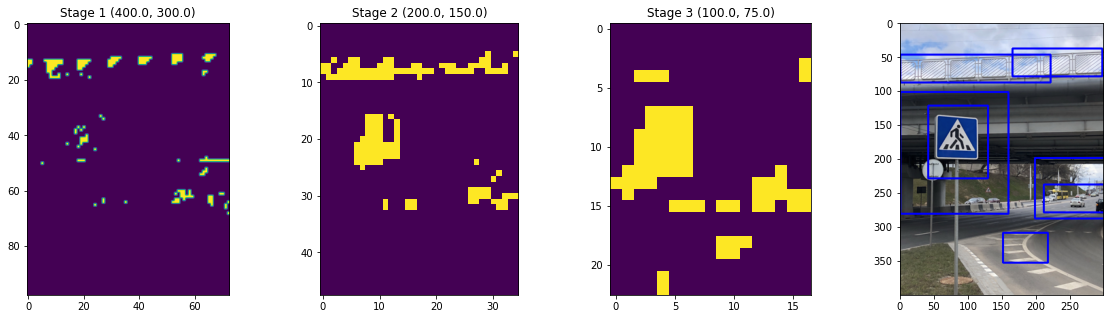

In [81]:
# raw_img = cv2.imread(os.path.join(train_dir, 'road155.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road198.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road202.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road215.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road797.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road655.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road420.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road123.png'))
raw_img = cv2.imread(os.path.join(train_dir, 'road178.png'))
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

def get_bboxes_pnet(raw_img, threshold=0.5, nms_threshold=0.5,
                    scale_factor=2.0, min_img_size = 48, padding = 0.15, visualize=False):
    '''
        
    '''
    H, W = raw_img.shape[:2]
    images = [raw_img]
    current_h, current_w = raw_img.shape[:2]
    
    ### 1. Get image pyramid ###
    while(current_h > min_img_size and current_w > min_img_size):
        current_h = int(current_h / scale_factor)
        current_w = int(current_w / scale_factor)

        if(current_w < min_img_size or current_h < min_img_size) : break

        image = cv2.resize(raw_img, (current_w, current_h))
        images.append(image)

    ### 2. Get bounding boxes from each image in the pyramid ###
    boxes = []
    conf_maps_viz = []
    for i, image in enumerate(images):
        if(i == 0): scale = 1
        else : scale = scale_factor ** i

        img = (image - 127.5) / 127.5
        height, width = image.shape[:2]

        predictions = pnet.predict(np.array([img]))
        features_shape = predictions[1][0].shape[:2]

        scale_w = width / features_shape[1]
        scale_h = height / features_shape[0]

        bboxes = predictions[1][0]
        raw_bboxes = bboxes
        confidence = predictions[0][0]

        ### Getting confidence map ###
        conf_map = confidence[:, :, 1]
        conf_map[conf_map > threshold] = 1.0
        conf_map[conf_map <= threshold] = 0
        conf_map = (conf_map * 255).astype(np.uint8)
        contours, hierarchy = cv2.findContours(conf_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        conf_maps_viz.append(conf_map)
        
        for contour in contours:
            rect = cv2.boundingRect(contour)
            x, y, w, h = (rect * np.array([W/conf_map.shape[1],H/conf_map.shape[0],W/conf_map.shape[1],H/conf_map.shape[0] ])).astype(int)

            x -= min(int(padding * w), x)
            y -= min(int(padding * h), y)
            w += 2*int(padding * w)
            h += 2*int(padding * h)
            if(w * h < (W * H)/64): continue
            boxes.append([x,y,w,h])
    
    ### Performing nms ###
    final_boxes = []
    pick = __nms(np.array(boxes), np.ones((len(boxes))), nms_threshold, 'Min')
    for i in range(len(boxes)):
        final_boxes.append(boxes[i])
        
    crops = []
    if(visualize):
        fig, ax = plt.subplots(1, len(conf_maps_viz) + 1, figsize=(5*(len(conf_maps_viz) + 1), 5))
        for i in range(len(conf_maps_viz)):
            current_size = (H // (scale_factor ** i),W // (scale_factor**i))
            ax[i].imshow(conf_maps_viz[i])
            ax[i].set_title(f'Stage {i+1} {current_size}')
        
    raw_img_copy = raw_img.copy()
    for (x, y, w, h) in final_boxes:
        cv2.rectangle(raw_img_copy, (x,y), (x+w, y+h), (0,0,255),2)
        crops.append([(x,y,w,h), raw_img[y:y+h, x:x+w]])
            
    if(visualize):
        plt.imshow(raw_img_copy)
        plt.show()
        
    return final_boxes, crops
        
boxes, crops = get_bboxes_pnet(raw_img, visualize=True)

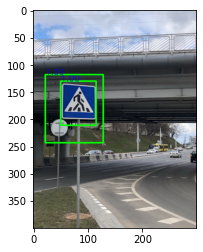

In [82]:
raw_img_copy = raw_img.copy()
for i in crops:
    crop = i[1]
    (x, y, w, h) = i[0]
    H, W = crop.shape[:2]
    img = cv2.resize(crop, (input_dim*4, input_dim*4))
    img = (img - 127.5) / 127.5
    
    prediction = onet.predict(np.array([img]))
    confidence = prediction[0][0][0][0]
    
    label = np.argmax(confidence)
    confidence = confidence[np.argmax(confidence)]
    
    bbox = prediction[1][0][0][0]
    if(confidence < 0.8 or label == 0):continue
    
    x_,y_,w,h = (bbox * np.array([W, H, W, H])).astype('uint8')
    x+=x_
    y+=y_
    
    raw_img_copy = cv2.rectangle(raw_img_copy, (x, y), (x+w, y+h), (0,255,0), 2)
    raw_img_copy = cv2.putText(raw_img_copy, f'{confidence:.2f}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255))
    
plt.imshow(raw_img_copy)
plt.show()